In [1]:
from __future__ import division
%matplotlib inline
%config InlineBackend.figure_format='retina'
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

#inititate Plotly
pyoff.init_notebook_mode()

In [2]:
SAVE_PROCESSED_DATA = True

In [3]:
scriptDir = os.getcwd()
relPath = r"../Customer Segmentation/"
sampleFilePath = os.path.join(scriptDir, relPath, 'CJ filtered.csv')
relPathOutput = r"../Customer Segmentation/output/"
outputFolderPath = os.path.join(scriptDir, relPathOutput)

In [4]:
df = pd.read_csv(sampleFilePath, sep=',', header=0, quotechar='"', encoding='latin1')
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (12810, 19)


In [5]:
df['booked date'] = pd.to_datetime(df['booked date'])
df['creation date'] = pd.to_datetime(df['creation date'])
df['Flight date'] = pd.to_datetime(df['Flight date'])

# Customer Segmentation

In [6]:
from sklearn.preprocessing import MinMaxScaler

## Recency
- find out most recent purchase date of each customer and see how many days they are inactive for.

In [7]:
df_user = pd.DataFrame(df['companyid'].unique())
df_user.columns = ['CompanyID']

In [8]:
df_max_purchase = df.groupby('companyid')['booked date'].max().reset_index()
df_max_purchase.columns = ['CompanyID', 'MaxPurchaseDate']

df_max_purchase['Recency'] = (df_max_purchase['MaxPurchaseDate'].max() - \
                             df_max_purchase['MaxPurchaseDate']).dt.days

In [9]:
df_user = pd.merge(df_user, df_max_purchase[['CompanyID', 'Recency']], on='CompanyID')
df_user.head()

CompanyID  Recency
0       2894      250
1       2482     2096
2       2783      481
3       2209     1384
4       4040     2196

In [10]:
plot_data = [
    go.Histogram(
        x=df_user['Recency'],
        opacity=0.75)
]

plot_layout = go.Layout(
            title = 'Recency Purchase From Customers Since 2014 (By days)')

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [11]:
df_user['R_log'] = np.log10(df_user['Recency'])

In [12]:
df_user[df_user['Recency'] == 0]

CompanyID  Recency  R_log
1007       1755        0   -inf

In [13]:
df_user.iloc[1007, 2] = 0 

In [14]:
scaler = MinMaxScaler()
df_user['Scaled_R'] = scaler.fit_transform(df_user[['R_log']])

The shape of the distribution satisify our expectation that larger number of customer has made purchase recently, and the first lost customer hasn't made purchase for 5 years and 8 months (companyid = 2482).

### Elbow Method 
In order to determine the optimal cluster number for optimal inertia.

In [15]:
from sklearn.cluster import KMeans

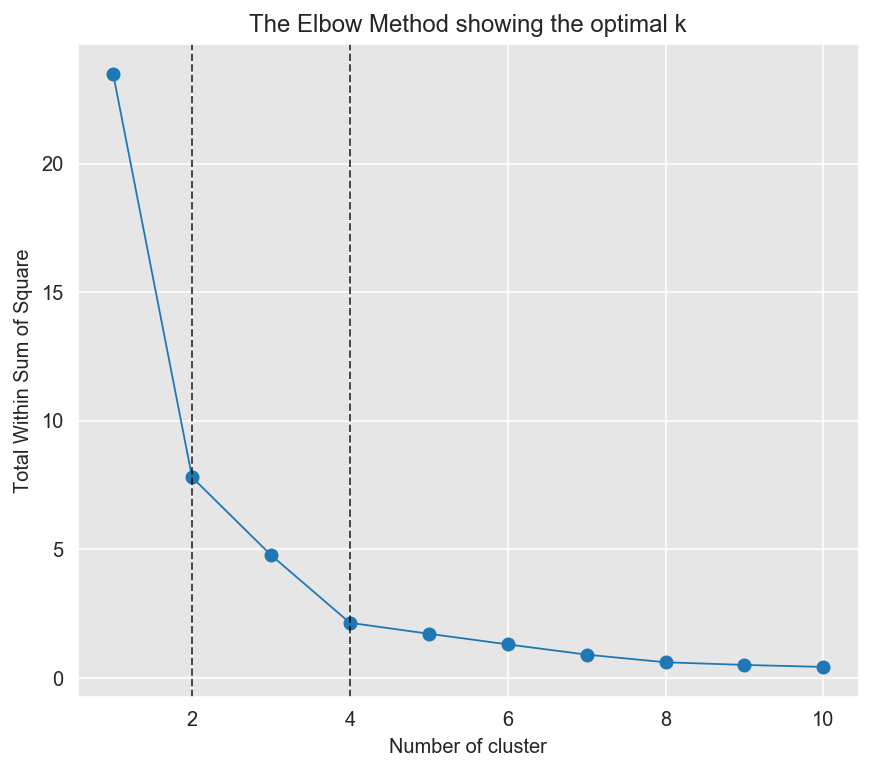

In [52]:
sse={}
df_recency = df_user[['Scaled_R']]
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
fig = plt.figure(figsize=(7,6), dpi=72)
plt.plot(list(sse.keys()), list(sse.values()), '-o', linewidth=0.9)
plt.xlabel("Number of cluster")
plt.ylabel('Total Within Sum of Square')
plt.title('The Elbow Method showing the optimal k', fontsize='large')
plt.axvline(x=2, color='black', linestyle = '--', alpha=0.7, linewidth=1)
plt.axvline(x=4, color='black', linestyle = '--', alpha=0.7, linewidth=1)
plt.show()

In [17]:
kmeans = KMeans(n_clusters=5, init='k-means++', 
                n_init=10,max_iter=500, tol=1e-04, 
                random_state=101)
kmeans.fit(df_user[['Scaled_R']])
df_user['RecencyCluster'] = kmeans.predict(df_user[['Scaled_R']])

In [18]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [19]:
df_user = order_cluster('RecencyCluster', 'Recency', df_user, False)

In [20]:
df_user.groupby('RecencyCluster')['Recency'].describe()

count         mean         std     min      25%     50%  \
RecencyCluster                                                            
0               406.0  1581.536946  293.761905  1106.0  1329.25  1564.0   
1               258.0   795.813953  146.874110   551.0   665.75   795.5   
2               214.0   398.607477   97.218524   220.0   329.00   407.5   
3               157.0   131.006369   45.640386    45.0    97.00   132.0   
4                35.0    19.942857   12.801523     0.0    10.50    17.0   

                    75%     max  
RecencyCluster                   
0               1838.00  2204.0  
1                897.50  1097.0  
2                481.75   550.0  
3                171.00   215.0  
4                 33.00    41.0

## Length of Relationship
- find out the longest relationship

In [21]:
df['LOAD_TIME'] = pd.to_datetime('22-07-2019')
df['DATEDIFF'] = (df['LOAD_TIME'] - pd.to_datetime(df['booked date'])).dt.days

df_length = df.groupby('companyid')['DATEDIFF'].max().reset_index()

In [22]:
df_length.columns = ['CompanyID', 'Length']

df_user = pd.merge(df_user, df_length, on='CompanyID')

In [23]:
plot_data = [
    go.Box(
        y= df_user.query('Recency < 720')['Length'],
        opacity=0.75,
        name = 'Customer that has not been lost',
        marker=dict(color='rgba(12, 50, 196, 0.6)')),
    go.Box(
        y= df_user.query('Recency > 720')['Length'],
        opacity=0.75,
        name = 'Lost Customer',
        marker=dict(color='rgba(171, 50, 96, 0.6)'))
]

plot_layout = go.Layout(
            barmode = 'overlay',
            title = "Lost vs Not Lost (Length of Customers Relationship)",
            xaxis = dict(title='Days Since the Customer First Time Used the Service'))

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [24]:
df_user['L_log'] = np.log10(df_user['Length'])
df_user['Scaled_L'] = scaler.fit_transform(df_user[['L_log']])

In [25]:
kmeans = KMeans(n_clusters=5, init='k-means++', 
                n_init=10,max_iter=500, tol=1e-04, 
                random_state=101)
kmeans.fit(df_user[['Scaled_L']])
df_user['LengthCluster'] = kmeans.predict(df_user[['Scaled_L']])

df_user = order_cluster('LengthCluster', 'Length',df_user,True)

In [26]:
df_user.groupby('LengthCluster')['Length'].describe()

count         mean         std     min      25%     50%  \
LengthCluster                                                            
0               54.0   128.166667   50.474634    11.0    95.50   136.5   
1              106.0   429.094340   92.687548   224.0   357.00   449.5   
2              190.0   790.594737  116.684847   579.0   680.00   794.0   
3              254.0  1319.169291  158.907432  1022.0  1181.25  1313.5   
4              466.0  1890.401288  159.920047  1572.0  1778.75  1922.0   

                   75%     max  
LengthCluster                   
0               166.25   201.0  
1               509.25   558.0  
2               879.50  1004.0  
3              1467.75  1565.0  
4              2002.00  2334.0

## Frequency
- Find total number orders for each customer.

In [27]:
df_frequency = df.groupby('companyid')['booked date'].count().reset_index()
df_frequency.columns = ['CompanyID', 'Frequency']

df_user = pd.merge(df_user, df_frequency, on='CompanyID')

In [28]:
plot_data = [
    go.Histogram(x=df_user['Frequency'])
]

plot_layout = go.Layout(
        title = 'Frequency of Customer Purchase Since 2014 (By Counts)')
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)
### CustomerID = 44 and 45

In [29]:
df_user['F_log'] = np.log10(df_user['Frequency'])
df_user['Scaled_F'] = scaler.fit_transform(df_user[['F_log']])

In [30]:
kmeans = KMeans(n_clusters=5, init='k-means++', 
                n_init=10,max_iter=500, tol=1e-04, 
                random_state=101)
kmeans.fit(df_user[['Scaled_F']])
df_user['FrequencyCluster'] = kmeans.predict(df_user[['Scaled_F']])

#order the frequency cluster
df_user = order_cluster('FrequencyCluster', 'Frequency',df_user,True)

In [31]:
df_user.groupby('FrequencyCluster')['Frequency'].describe()

count        mean         std   min   25%    50%     75%  \
FrequencyCluster                                                             
0                 460.0    1.000000    0.000000   1.0   1.0    1.0    1.00   
1                 266.0    2.296992    0.457795   2.0   2.0    2.0    3.00   
2                 196.0    6.224490    2.205032   4.0   4.0    6.0    7.25   
3                 109.0   25.412844   11.967712  12.0  15.0   21.0   33.00   
4                  39.0  198.692308  277.397791  57.0  72.0  104.0  190.50   

                     max  
FrequencyCluster          
0                    1.0  
1                    3.0  
2                   11.0  
3                   54.0  
4                 1369.0

## Miles (Sum)
- Find the sum of miles for each customer
- (ID)212 : 4136918.96; (ID)213 : 2710658.42

In [32]:
df_miles = df.groupby('companyid')['Total Distance (NMi)'].sum().reset_index()
df_miles.columns = ['CompanyID', 'Miles']

df_user = pd.merge(df_user, df_miles, on='CompanyID')

In [33]:
plot_data = [
    go.Histogram(
        x= df_user.query('Recency < 720')['Miles'],
        opacity=0.75,
        name = 'Customer that has not been lost',
        marker=dict(color='rgba(12, 50, 196, 0.6)')),
    go.Histogram(
        x= df_user.query('Recency > 720')['Miles'],
        opacity=0.75,
        name = 'Lost Customer',
        marker=dict(color='rgba(171, 50, 96, 0.6)'))
]

plot_layout = go.Layout(
        barmode = 'overlay',
        title = 'Lost/Not Lost (Sum of Miles of Customer Since 2014)')
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [34]:
df_user['M_log'] = np.log10(df_user['Miles'])
df_user['Scaled_M'] = scaler.fit_transform(df_user[['M_log']])

In [35]:
kmeans = KMeans(n_clusters=5, init='k-means++', 
                n_init=10,max_iter=500, tol=1e-04, 
                random_state=101)
kmeans.fit(df_user[['Scaled_M']])
df_user['MilesCluster'] = kmeans.predict(df_user[['Scaled_M']])

df_user = order_cluster('MilesCluster', 'Miles',df_user,True)

In [36]:
df_user.groupby('MilesCluster')['Miles'].describe()

count           mean            std       min        25%  \
MilesCluster                                                             
0             277.0     707.079531     249.572162     96.48    508.700   
1             374.0    2102.810722     692.834052   1143.88   1512.365   
2             231.0    6823.050303    2327.998287   3591.84   4776.145   
3             129.0   26592.759225   12952.053910  12480.83  15716.320   
4              59.0  319278.279153  623783.774712  67713.36  88025.200   

                    50%         75%         max  
MilesCluster                                     
0                735.46     913.980     1126.00  
1               1923.82    2644.110     3581.14  
2               6500.47    8492.765    12333.00  
3              22800.96   34096.990    63787.42  
4             147532.91  287408.350  4136918.96

## Gross Profit (Average)
- let's see how our customer database looks like when we cluster them based on revenue.

In [37]:
df_gross = df.groupby('companyid').gross.mean().reset_index()
df_gross.columns = ['CompanyID', 'GrossProfit']

df_user = pd.merge(df_user, df_gross, on = 'CompanyID')

In [38]:
plot_data = [
    go.Histogram(
        x= df_user.query('Frequency > 6')['GrossProfit'],
        opacity=0.75,
        name = 'Existing Customer',
        marker=dict(color='rgba(12, 50, 196, 0.6)')),
    go.Histogram(
        x= df_user.query('Frequency <= 6')['GrossProfit'],
        opacity=0.75,
        name = 'New Customer',
        marker=dict(color='rgba(171, 50, 96, 0.6)'))
]

plot_layout = go.Layout(
        barmode = 'overlay',
        title = 'Existing/New Customer (Average Gross Profit of Customer Since 2014)')
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [39]:
df_user['C_log'] = np.log10(df_user['GrossProfit'])
df_user['Scaled_C'] = scaler.fit_transform(df_user[['C_log']])

In [40]:
kmeans = KMeans(n_clusters=5, init='k-means++', 
                n_init=10,max_iter=500, tol=1e-04, 
                random_state=101)
kmeans.fit(df_user[['Scaled_C']])
df_user['GrossCluster'] = kmeans.predict(df_user[['Scaled_C']])

df_user = order_cluster('GrossCluster', 'GrossProfit',df_user,True)

## Overall Score

In [41]:
df_user['OverallScore'] = df_user['LengthCluster'] + df_user['RecencyCluster'] + df_user['FrequencyCluster'] + df_user['MilesCluster'] + df_user['GrossCluster']  

In [42]:
table = df_user.groupby('OverallScore')['Length', 'Recency', 'Frequency', 'Miles', 'GrossProfit'].mean()
table['No.of Customers'] = df_user.groupby('OverallScore')['CompanyID'].count()

In [43]:
df_user['Segment'] = 'Low-Value'
df_user.loc[df_user['OverallScore']>7, 'Segment'] = 'Mid-Value'
df_user.loc[df_user['OverallScore']>14, 'Segment'] = 'High-Value'

In [44]:
plot_data = [
    go.Scatter(
        x = df_user.query("Segment == 'Low-Value'")['Recency'],
        y = df_user.query("Segment == 'Low-Value'")['GrossProfit'],
        mode = 'markers',
        name = 'Low',
        marker = dict(size = 7, line = dict(width=1),
                     color = 'blue', opacity = 0.8)),
    go.Scatter(
        x = df_user.query("Segment == 'Mid-Value'")['Recency'],
        y = df_user.query("Segment == 'Mid-Value'")['GrossProfit'],
        mode = 'markers',
        name = 'Mid',
        marker = dict(size = 9, line = dict(width=1),
                     color = 'green', opacity = 0.5)),
    go.Scatter(
        x = df_user.query("Segment == 'High-Value'")['Recency'],
        y = df_user.query("Segment == 'High-Value'")['GrossProfit'],
        mode = 'markers',
        name = 'High',
        marker = dict(size = 11, line = dict(width=1),
                     color = 'red', opacity = 0.9)),
]

plot_layout = go.Layout(
        yaxis = {'title':'Gross Profit'},
        xaxis = {'title':'Recency'},
        title = 'Segments of Customer Value')

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

The scoring above clearly shows us that customers with score 19 is our best customer whereas 0 is the worst.
- 3 to 7: Low Value - Improve Retention
- 8 to 14: Mid Value - Improve Retention + Increase Frequency
- 15+: High Value - Increase Frequency

### Silhouette analysis on K-Means clustering

In [45]:
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabaz_score
import matplotlib.cm as cm

In [54]:
lrfmc_table = df_user.groupby('CompanyID')['Scaled_L', 'Scaled_R', 'Scaled_F', 'Scaled_M', 'Scaled_C'].mean()

cluster_centers = dict()
feature_vector = ['Scaled_L', 'Scaled_R', 'Scaled_F', 'Scaled_M', 'Scaled_C']
subset = df_user[feature_vector]

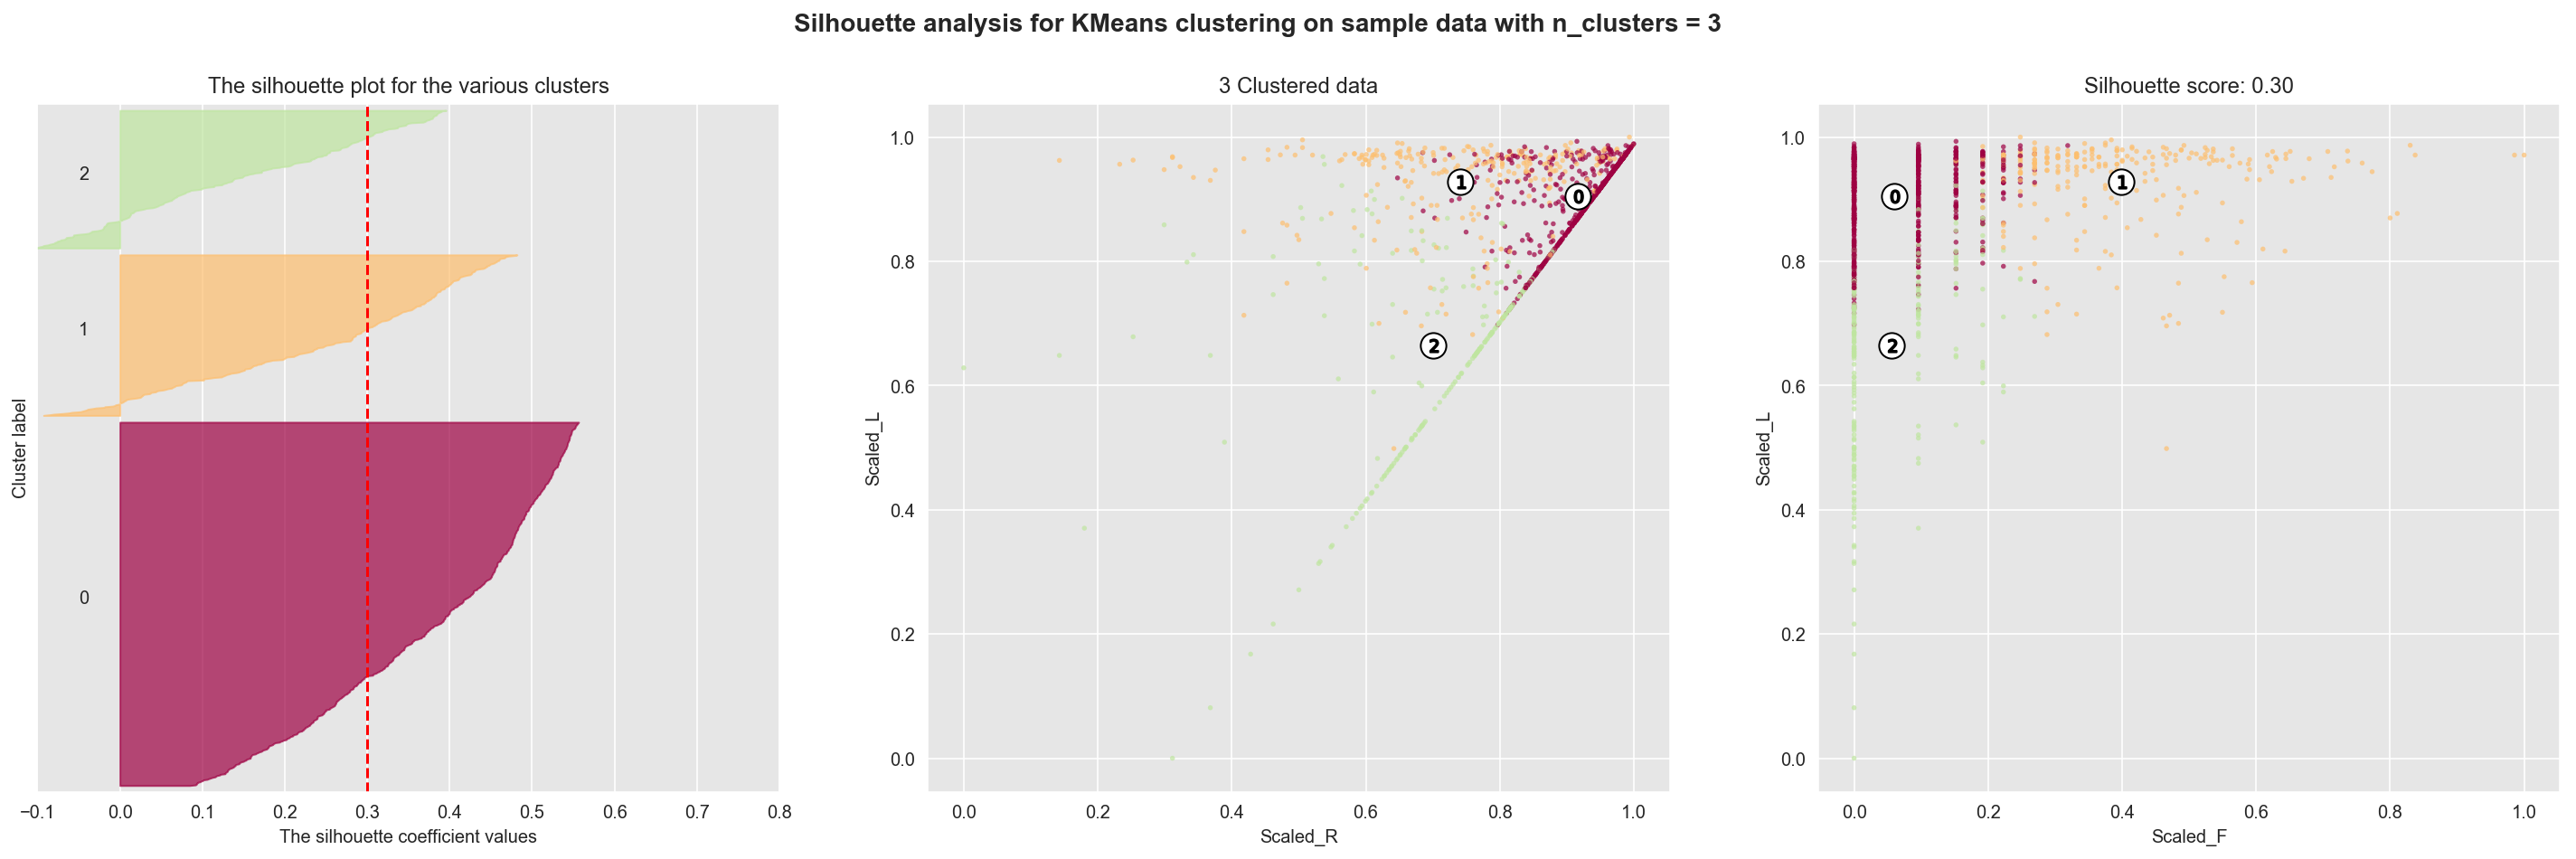

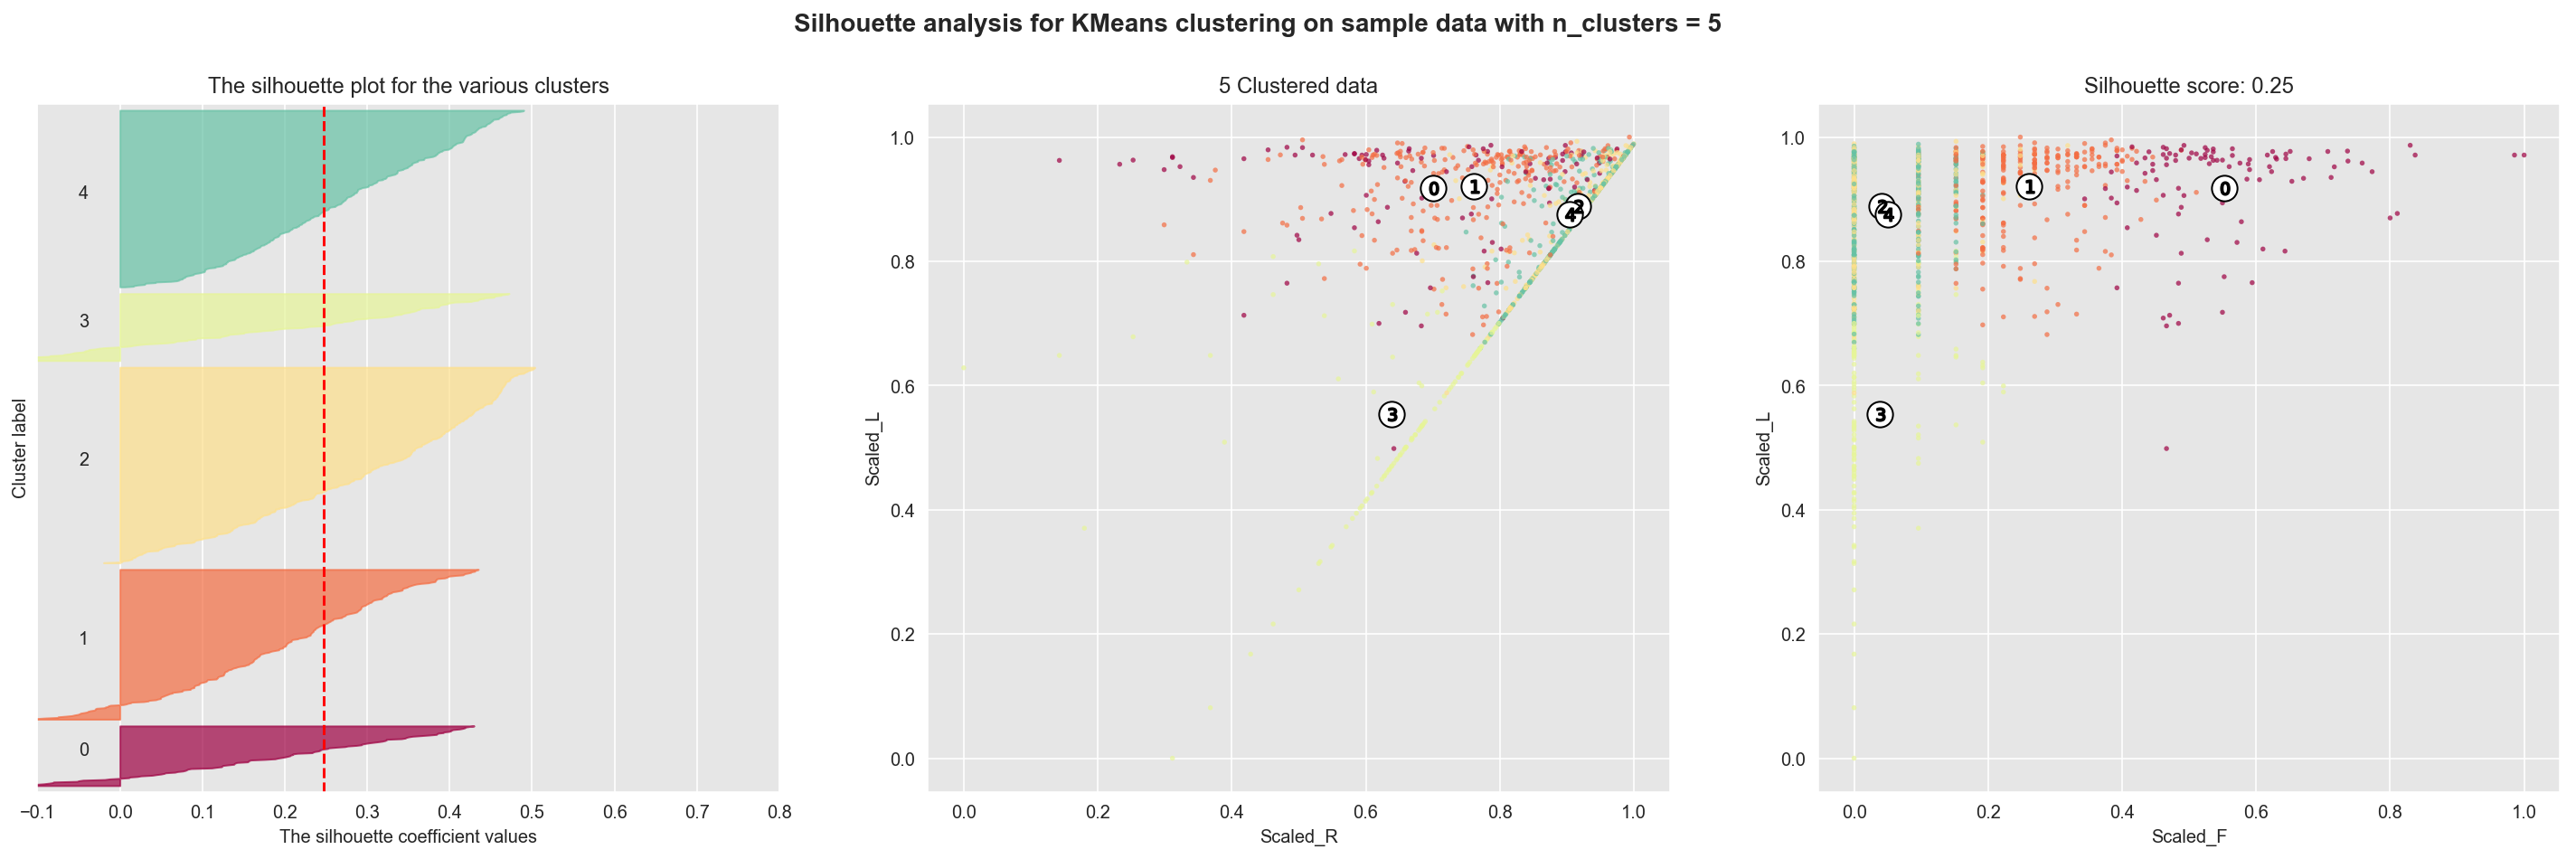

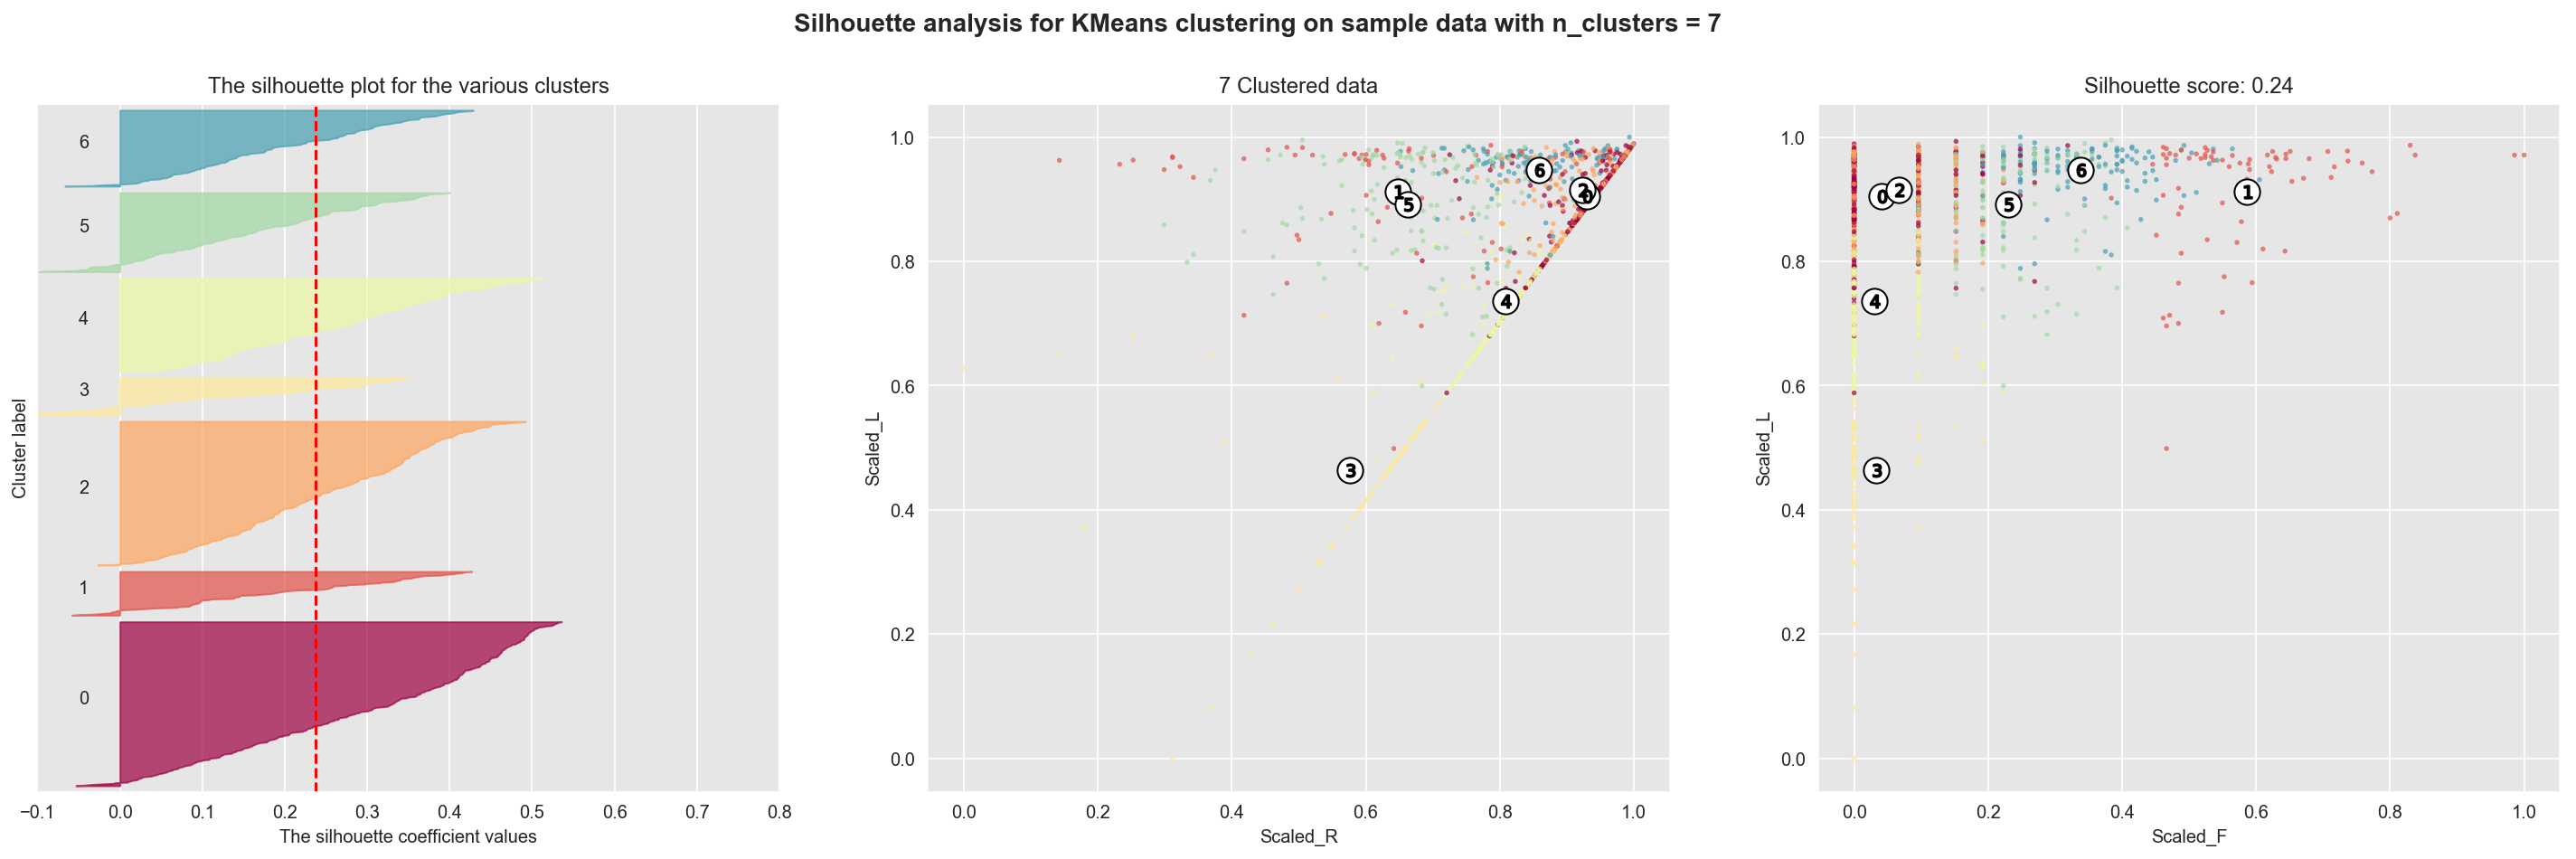

In [47]:
for n_clusters in range(3, 8, 2):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(25, 7)
    ax1.set_xlim([-0.1, 0.8])
    ax1.set_ylim([0, len(lrfmc_table) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10,max_iter=500, tol=1e-04, random_state=101)
    cluster_labels = clusterer.fit_predict(lrfmc_table)

    silhouette_avg = silhouette_score(X = lrfmc_table, labels = cluster_labels)
    cluster_centers.update({n_clusters :{'cluster_center':clusterer.cluster_centers_,
                                         'silhouette_score':silhouette_avg,
                                         'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X = lrfmc_table, labels = cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    
    centers = clusterer.cluster_centers_
    y = 0
    x = 1
    ax2.scatter(lrfmc_table.iloc[:, x], lrfmc_table.iloc[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax2.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax2.set_title("{} Clustered data".format(n_clusters))
    ax2.set_xlabel(feature_vector[x])
    ax2.set_ylabel(feature_vector[y])

    x = 2
    ax3.scatter(lrfmc_table.iloc[:, x], lrfmc_table.iloc[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax3.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax3.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax3.set_title("Silhouette score: {:1.2f}".format(cluster_centers[n_clusters]['silhouette_score']))
    ax3.set_xlabel(feature_vector[x])
    ax3.set_ylabel(feature_vector[y])
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    fig.savefig('silhouette.png')
    plt.show

**In the three-cluster:**
- The tree clusters appears have a good stark differences in the length value of the customer, we will confirm this by a box plot.
- Cluster 0 is the cluster of high value customer who shops frequently and is certainly an important segment for each business.
- In the similar way we obtain customer groups with low and medium spends in clusters with labels 2 and 1, respectively.
- Frequency and Recency correlate perfectly to the Monetary value based on the trend (High Monetary-Low Recency-High Frequency).

**In the five-cluster:**
- Note that clusters 1 is very similar to their cluster in the configuration with only 3 clusters.
- The cluster 1 appears more robust on the affirmation of those who shop often and with high amount.
- The cluster 0 is those who have a decent spend but are not as frequent as the cluster 1
- The cluster 2 is the new customers who spend our service recently but haven't commited the customer loyalty.
- The cluster 3 purchases high amounts, with a relatively low frequency and not very recent
- The cluster 4 makes low-cost purchases, with a relatively low frequency, but above 1, and made their last purchase more recently. This group of customers probably response to price discounts and can be subject to loyalty promotions to try increase the medium-ticket, strategy that can be better defined when we analyzing the market basket.
- The silhouette score matrix says that the five cluster segments are less optimal then the three cluster segments.

**In the Seven-cluster:**
- Definitely cluster 2 defines those who shop often and with medium amount.
- Clusters 1 and 5 show good spending and good frequency, only deferring in how recent were their last purchases, where 5 is older, which suggests an active action to sell to group 5 as soon as possible and another to 1 seeking to raise its frequency.
- Cluster 0 presents the fourth best purchase and a reasonable frequency, but this is a long time without buying. This group should be sensible to promotions and activations, so that they do not get lost and make their next purchase.
- Cluster 6 is similar to 0, but has made its purchases more recently and has a slightly better periodicity. Then actions must be taken to raise their frequency and reduce the chances of them migrating to cluster 0 by staying longer without purchasing products.